# DATA20001 Deep Learning - Group Project
## Image project

**Due Wednesday December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imageio.imread`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- Loading all the images into one big matrix as we have done in the exercises is not feasible (e.g. the virtual servers in CSC have only 3 GB of RAM). You need to load the images in smaller chunks for the training. This shouldn't be a problem we are doing mini-batch training anyway, and thus we don't need to keep all the images in memory. You can simply pass you current chunk of images to `model.fit()` as it remembers the weights from the previous run.

- You need to think carefully about how you load the annotations and match them up with the corresponding images, especially as you are loading them in smaller chunks.

## Download the data

In [ ]:
from keras.utils.data_utils import get_file

database_path = 'train/'

dl_file='dl2017-image-proj.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=database_path, extract=True)

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
from scipy.misc import imread


n = 20000

# normalizing range to be in 0.0 to 1.0
normalize_values = True

my_dtype = "uint8"
if normalize_values:
    my_dtype = np.float32
    
x_color = np.zeros((n, 128, 128, 3), dtype=my_dtype)
for i in range(n):
    img = imread("train/images/im" + str(i+1) +".jpg")
    if normalize_values:
        img = img / 255
    if len(img.shape) == 3:
        x_color[i] = img
    else:    
        x_color[i] = np.repeat(img[:,:,np.newaxis], 3, axis=2)
        

In [2]:
num_classes = 14 + 1
UNCLASSIFIED_BIT = 14
labels = {
  0: 'baby',
  1: 'bird',
  2: 'car',
  3: 'clouds',
  4: 'dog',
  5: 'female',
  6: 'flower',
  7: 'male',
  8: 'night',
  9: 'people',
  10: 'portrait',
  11: 'river',
  12: 'sea',
  13: 'tree',
  UNCLASSIFIED_BIT: "unclassified"
}

labels_rev = {v: k for k, v in labels.items()}

In [3]:
# The labels are made into onehot vectors straight away
y = np.zeros((n, num_classes), dtype="uint8")

folder = "train/annotations/"
for num, label in labels.items():
    if num == UNCLASSIFIED_BIT:
        continue
    with open(folder + label +".txt", "r") as f:
        for line in f.readlines():
            # The indexing starts from 1 in dataset, but is converted to starting from 0
            y[int(line.strip())-1, num] = 1

for row in y:
    if sum(row) == 0:
        row[UNCLASSIFIED_BIT] = 1

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_color, y, test_size=0.2, random_state=142)

In [ ]:
x_train.shape

In [ ]:
plt.subplot(1,2,1)
plt.imshow(imread("train/images/im7.jpg"), cmap='Greys_r', interpolation='none')
plt.title("Original B&W")

plt.subplot(1,2,2)
plt.imshow(np.repeat(misc.imread("train/images/im7.jpg")[:,:,np.newaxis], 3, axis=2))
plt.title("Modified RGB B&W")

plt.tight_layout()

In [ ]:
print("Total amount of labels: %s" % str(np.sum(y)))

In [ ]:
# Some plotting of first instances of each class

for l in range(num_classes):
    idx = np.argwhere(y[:,l]==1)[0]
    
    
    plt.subplot(3, 5, l+1)
    
    img = x_color[idx].reshape(128, 128, 3)
        
    plt.imshow(img)
    plt.title(labels[l])
    plt.axis('off')


In [47]:
# Some statistics
print("Amount of images with no class: %d" % (np.where(np.sum(y, axis=1) == 0)[0].shape[0]))
print("Amount of images per class:")
for i, l in enumerate(np.sum(y, axis=0)):
    print("   %s: %d" % (labels[i], l))

Amount of images with no class: 0
Amount of images per class:
   baby: 95
   bird: 360
   car: 319
   clouds: 1095
   dog: 448
   female: 3227
   flower: 761
   male: 2979
   night: 598
   people: 6403
   portrait: 3121
   river: 120
   sea: 173
   tree: 525
   unclassified: 9824


In [6]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, Dropout

Using TensorFlow backend.


In [40]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [67]:
# Definition of custom metrics as the project is ranked with F1 score
from sklearn.metrics import f1_score

def f1__score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [77]:
a = np.array([[0, 1, 0, 1, 0],
     [0, 1, 0, 1, 0]])
b = np.array([[0, 1, 0, 1, 1],
     [0, 1, 0, 1, 0]])

print(f1__score_micro(a, b))

0.888888888889


In [52]:
model = Sequential()

# Add layers here

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation("sigmoid"))


model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['binary_accuracy', 'categorical_accuracy', f1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
activation_29 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 64)        18496     
__________

In [42]:
%%time

epochs = 1

history = model.fit(x_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/1
16000/16000 [==============================] - 223s - loss: 0.2530 - binary_accuracy: 0.8971 - categorical_accuracy: 0.4057 - f1: nan   
CPU times: user 14min 43s, sys: 2min 23s, total: 17min 6s
Wall time: 3min 44s


In [43]:
scores = model.evaluate(x_test, y_test, verbose=2)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

binary_accuracy: 90.15%
categorical_accuracy: 29.48%


In [44]:
threshold = 0.5

pred = model.predict(x_test)
pred[np.where(pred > threshold)] = 1
pred[np.where(pred <= threshold)] = 0
y_pred = pred.astype(np.bool)
y_pred = y_pred[:, :num_classes-1]

In [45]:
from sklearn.metrics import f1_score

f1_score(y_test[:, :num_classes-1], y_pred, average='micro')

0.24880929700895407

In [22]:
print(list(np.sum(y_pred, axis=0)))

[0, 0, 0, 22, 0, 245, 3, 10, 11, 1080, 292, 0, 0, 0, 1635]


In [23]:
print(list(np.sum(y_test, axis=0)))

[28, 72, 65, 196, 71, 627, 123, 616, 120, 1305, 605, 27, 32, 96, 2014]


In [24]:
[labels[i] for (i,x) in enumerate(list(np.sum(y_pred, axis=0)))]

['baby',
 'bird',
 'car',
 'clouds',
 'dog',
 'female',
 'flower',
 'male',
 'night',
 'people',
 'portrait',
 'river',
 'sea',
 'tree',
 'unclassified']

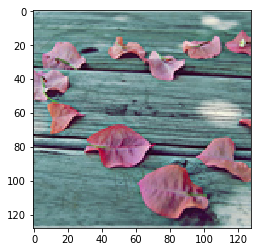

In [60]:
plt.imshow(x_color[1])

In [61]:
model.predict(x_color[1].reshape(1,128,128,3))

array([[ 0.50313419,  0.47709832,  0.53303647,  0.52879059,  0.52935779,
         0.47815457,  0.47757638,  0.56035107,  0.47890252,  0.47099525,
         0.46966496,  0.45704791,  0.47477341,  0.53285795,  0.49130964]], dtype=float32)

In [66]:
[labels[i] for (i,x) in enumerate(y[706 -1]) if x]

['night']

In [28]:
y_pred_tmp = y_pred.copy()
y_test_tmp = y_test.copy()

y_pred_tmp[np.where(y_pred == 0)] = 88
y_test_tmp[np.where(y_test == 0)] = 99

In [29]:
np.sum(y_pred_tmp == y_test_tmp, axis=0)

array([  28,   72,   65,  196,   71,  627,  123,  616,  120, 1305,  605,
         27,   32,   96, 2014])

In [46]:
np.sum(y_test) / y_test.size

0.099949999999999997

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
model.save('model.h5')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Predict for test set

You will be asked to return your prediction for the testset.  These should be returned as a matrix with one row for each test set image.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
If you have the matrix prepared in `y` (e.g., by calling `y=model.predict(x_test)`) you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')